In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

(20,) (20, 2) (20, 2)
(200,) (200, 2) (200, 2)


ValueError: x and y must have same first dimension, but have shapes (20,) and (2,)

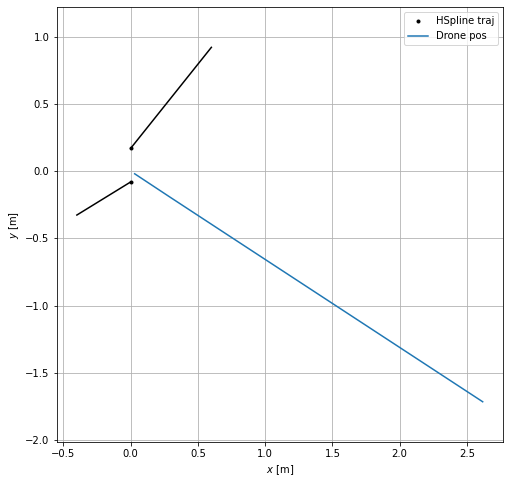

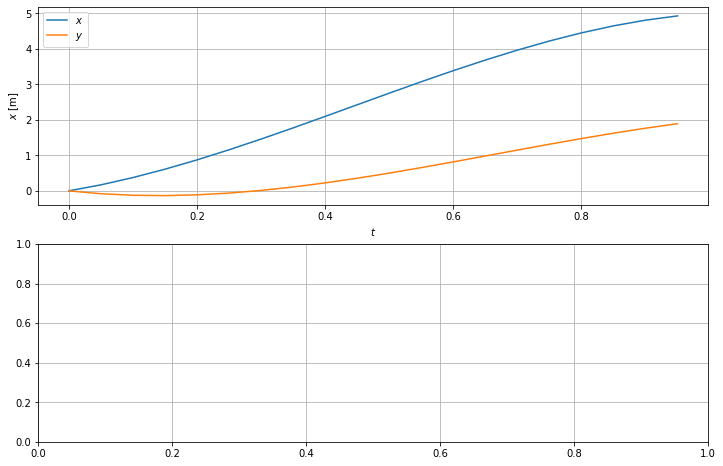

In [20]:
class HermiteSpline():
    """
    This class represents a 2D cubic hermite spline connecting the `origin` and `dest` points
    with velocity constraints `origin_vel` and `dest_vel`   
    """
    def __init__(self, origin, origin_vel, dest, dest_vel, dt=0.01):
        self.origin = origin
        self.origin_vel = origin_vel
        self.dest = dest
        self.dest_vel = dest_vel
        self.t = np.arange(0, 1, dt)
        
        self._H = np.array([
            origin, # h1
            origin_vel, # h2
            -3*origin - 2*origin_vel + 3*dest - dest_vel, # h3
            2*origin + origin_vel - 2*dest + dest_vel # h4
        ]).T
        self._T  = np.array([np.ones_like(self.t), self.t, np.power(self.t, 2), np.power(self.t, 3)])
        self._dT = np.array([np.zeros_like(self.t), np.ones_like(self.t), 2*self.t, 3*np.power(self.t, 2)])

        self.x = np.transpose(self._H.dot(self._T))
        self.v = np.transpose(self._H.dot(self._dT))
    
    def get_polynomial(self):
        """Get an array with the Hermite spline coefficients h1..h4"""
        return self._H
        
    def sample(self, t):
        """
        Sample the trajecoty at an arbitrary time `t` on the range <0, 1>.
        """
        x = self._H.dot(np.array([1.0, t, t**2, t**3]))
        v = self._H.dot(np.array([0.0, 1.0, 2*t, 3*t**2]))
        return x, v
  

class Drone():
    def __init__(self, origin, origin_vel, hspline, obstacles, duration, dt, 
                 setpoint_gain, velocity_gain, max_vel, max_accel):
        self.t = np.arange(0, duration, dt)
        self.dt = dt
        self.num_steps = len(self.t)
        
        # Parameters
        self.setpoint_gain = setpoint_gain
        self.velocity_gain = velocity_gain
        self.max_vel = max_vel
        self.max_accel = max_accel
        
        # Current state
        self.position = origin * 1.0 if origin is not None else np.zeros(2)
        self.velocity = origin_vel * 1.0 if origin_vel is not None else np.zeros(2)
        self.accelertion = np.zeros(2)
        
        # State history
        self.x = np.zeros((self.num_steps, 2)) # Pos 
        self.v = np.zeros((self.num_steps, 2)) # Vel
        self.a = np.zeros((self.num_steps, 2)) # Control input
        self.x[0] = self.position
        self.v[0] = self.velocity
        self.a[0] = self.accelertion
        
        self.hspline = hspline
        self.obstacles = obstacles
        
    def step(self, accel, step_idx, dt=.01):
        self.velocity += accel * dt
        self.position += self.velocity[:2] * dt
        self.acceleration = accel
        self.x[step_idx] = self.position
        self.v[step_idx] = self.velocity
        self.a[step_idx] = self.accelertion
        
    def simulate(self):
        for step in range(self.num_steps):
            accel_command = np.zeros(2)
            velocity_command = np.zeros(2)
            obstacle_accel = np.zeros(2)
            
#             velocity_command = (self.hspline.x[step,:] - self.position) * self.setpoint_gain
            
            # Simple velocity controller
            velocity_command = np.clip(velocity_command, -self.max_vel, self.max_vel)
            accel_command = -self.velocity_gain * (self.velocity - velocity_command)
            
            # Add obstacle accels
            accel_command[:3] += obstacle_accel
            accel_command = np.clip(accel_command, -self.max_accel, self.max_accel)
            
            self.step(accel_command, step)

origin = np.array([0, 0])
origin_vel = np.array([3, -2])
dest = np.array([5, 2])
dest_vel = np.array([1, 2])
dt = 1.0 / 20.0
duration = 10.0
obstacles = np.array([])

hs = HermiteSpline(origin, origin_vel, dest, dest_vel, dt)
drone = Drone(origin, origin_vel, hs, obstacles, duration, dt,
              setpoint_gain=1.0, velocity_gain=1.0,
              max_vel=5.0, max_accel=2.5)
drone.simulate()


t, x, v = hs.t, hs.x, hs.v
# t, x, v = drone.t, drone.x, drone.v
print(hs.t.shape, hs.x.shape, hs.v.shape)
print(drone.t.shape, drone.x.shape, drone.v.shape)

figsize = (8, 8)
vscale = 0.2


plt.figure(figsize=figsize)
plt.plot(x[0], x[1], 'k.', label='HSpline traj')
# plt.plot(x[:,0], v[:,0])
plt.plot([x[0,0], x[0,0] + v[0,0]*vscale], 
         [x[1,0], x[1,0] + v[1,0]*vscale], 'k')
plt.plot([x[0,-1], x[0,-1] + v[0,-1]*vscale], 
         [x[1,-1], x[1,-1] + v[1,-1]*vscale], 'k')
plt.plot(drone.x[:,0], drone.x[:,1], label='Drone pos')
plt.grid(True)
plt.axis('equal')
plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.legend()

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.grid(True)
plt.plot(t, x[:, 0], label='$x$')
plt.plot(t, x[:, 1], label='$y$')
plt.xlabel('$t$')
plt.ylabel('$x$ [m]')
plt.legend()
plt.subplot(212)
plt.grid(True)
plt.plot(t, v[0], label='$v_x$')
plt.plot(t, v[1], label='$v_y$')
plt.xlabel('$t$')
plt.ylabel('$v$ [m/s]')
plt.legend()



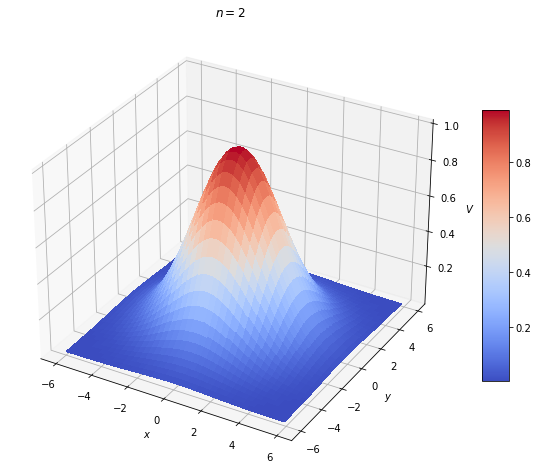

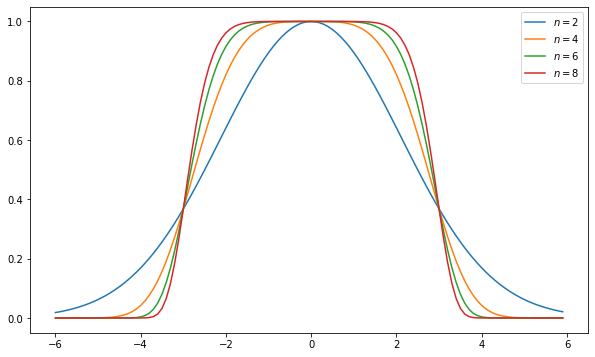

In [4]:
# Repulsive potential function from Santos et al. 2017 "A Novel Null-Space-Based UAV Trajectory Tracking Controller With Collision Avoidance"
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8049328
n = 2
a = 3
b = 3
size = 6

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-size, size, 0.1)
Y = np.arange(-size, size, 0.1)
XX, YY = np.meshgrid(X, Y)
V = np.exp(-(XX/a)**n - (YY/b)**n)

# # Plot the surface.
surf = ax.plot_surface(XX, YY, V, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title(r'$n=2$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$V$')
# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.figure(figsize=(10,6))
for n in [2, 4, 6, 8]:
    Vx = np.exp(-(X/a)**n)
    plt.plot(X, Vx, label=r'$n={}$'.format(n))
plt.legend()
plt.show()

In [5]:
np.exp(2)

7.38905609893065